<a href="https://colab.research.google.com/github/IllgamhoDuck/Quantum-Circuit-Optimization-with-Deep-learning/blob/master/Random_quantum_circuit_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Quantum Circuit Generator
**How to automatically generate Quantum Circuits and how to encode them**

This is a page that introduces how to use a random quantum circuit generator. This will be used to generate the dataset of quantum circuits.

### Setting environment
- package install
- package import

In [1]:
#!pip install --quiet qiskit nxpd

In [2]:
%matplotlib inline
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit.circuit.random.utils import random_circuit

 
 ## Random Circuit 
 **Generate random circuit of arbitrary size of form**

 ```def random_circuit(n_qubits, depth, max_operands=3, measure=False, conditional=False, reset=False, seed=None)```

    - n_qubits (int): number of quantum wires
    - depth (int): layers of operations (i.e. critical path length)
    - max_operands (int): maximum operands of each gate (between 1 and 3)
    - measure (bool): if True, measure all qubits at the end
    - conditional (bool): if True, insert middle measurements and conditionals
    - reset (bool): if True, insert middle resets
    - seed (int): sets random seed (optional)


**URL**

    - https://github.com/Qiskit/qiskit-terra/blob/master/qiskit/circuit/random/utils.py
    - https://github.com/Qiskit/qiskit-terra/blob/2582fae6a3cf020f5715d8ed58b492eb91a7604d/tools/random_qasm_generator.py

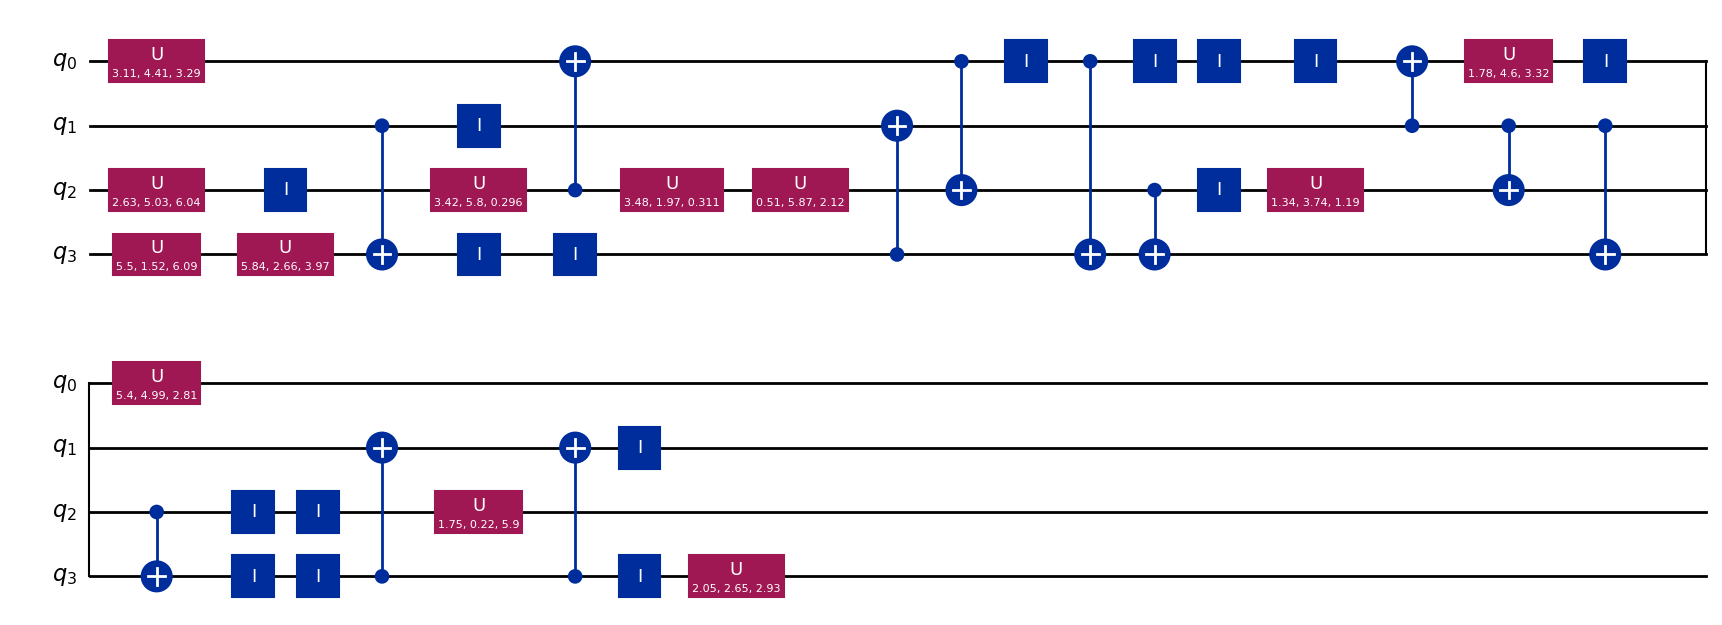

In [3]:
import random
from qiskit import QuantumCircuit

# Lista delle porte disponibili
gates = ['u','cx', 'id']

# Creiamo un circuito quantistico con 4 qubit
qc = QuantumCircuit(4)

# Funzione per generare parametri casuali
def random_parameters(num):
    return [random.uniform(0, 2 * 3.14159) for _ in range(num)]

# Inseriamo 40 porte casuali nel circuito
for _ in range(40):
    gate = random.choice(gates)
    if gate == 'p':
        qc.p(random_parameters(1)[0], random.randint(0, 3))
    elif gate == 'u':
        qc.u(random_parameters(3)[0], random_parameters(3)[1], random_parameters(3)[2], random.randint(0, 3))
    elif gate == 'cx':
        qubit1, qubit2 = random.sample(range(4), 2)
        qc.cx(qubit1, qubit2)
    elif gate == 'id':
        qc.id(random.randint(0, 3))

# Visualizziamo il circuito
qc.draw('mpl')



## Unroll
**Unroll the quantum circuit to basis gates**


gates =  OrderedDict([('id', 16), ('u', 12), ('cx', 12)])
depth =  22


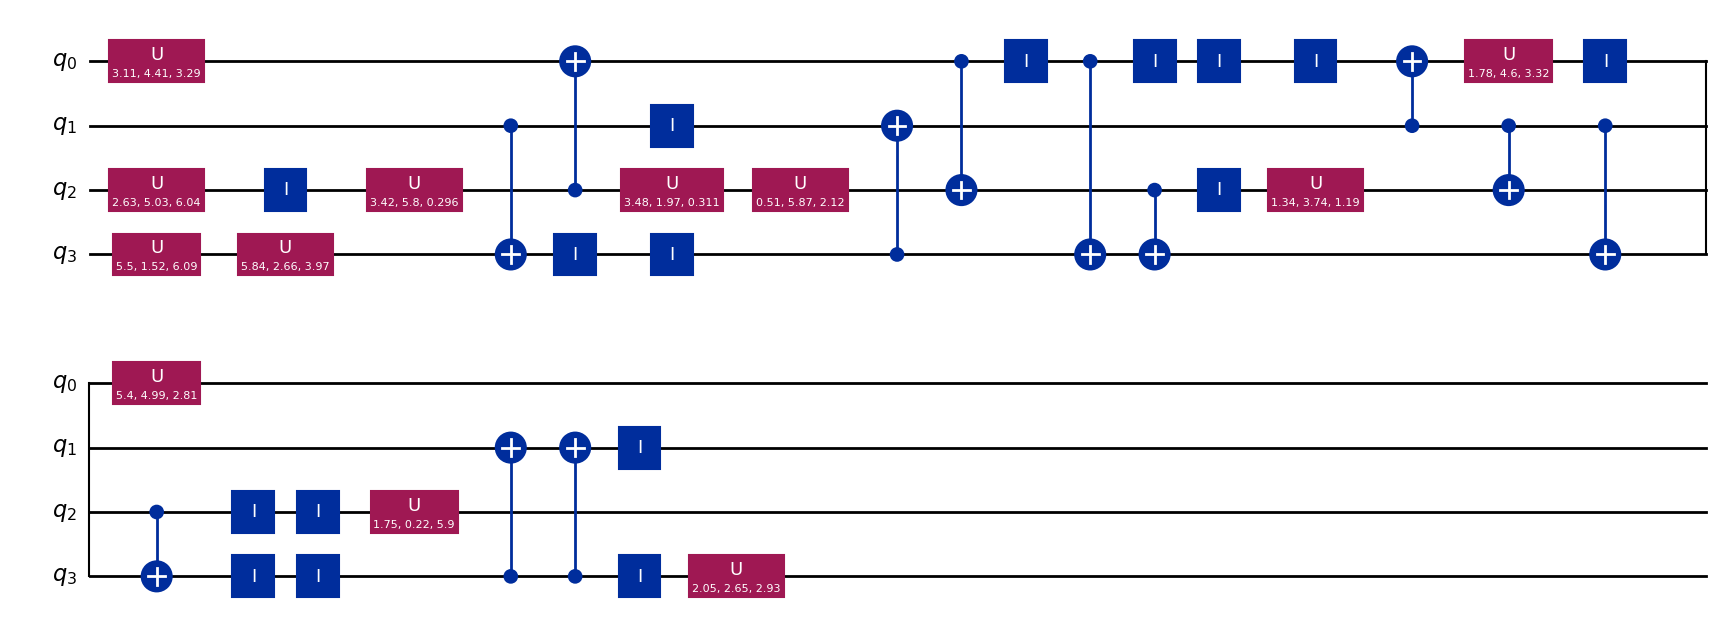

In [4]:
from qiskit.transpiler.passes import Unroll3qOrMore
pass_ = Unroll3qOrMore(target=qc,basis_gates=['u','cx', 'id'])
#Unroll3qOrMore
pm = PassManager(pass_)
unrolled = pm.run(qc)
print('gates = ', unrolled.count_ops())
print('depth = ', unrolled.depth())
unrolled.draw(output='mpl')

## Encode the circuit

**Encode each gates to node**

1. Translate quantum circuit to QASM format
2. Print QASM line by line and encode
3. Encode mode
- control not : [gate number, [qubit number list]]
- unitary : [gate number, [qubit number list], [angle list]]

**Example**
```
gate number depends on the basis_gates list index
basis_gates = ['u1', 'u2', 'u3', 'cx', 'id']
u1 - 0, u2 - 1, u3 - 2, cx - 3, id - 4
encode cx q[0],q[1] => [3, [0, 1]]
encode u3(pi,pi,pi) q[1] => [2, [1], [3.14, 3.14, 3.14]]
```


In [5]:
# Make quantum circuit to qasm
from qiskit.qasm2 import dumps
import io
import math
qasm_str=dumps(unrolled)

qasm_str=qasm_str+'_'
print(qasm_str)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
u(3.1145722715857476,4.40982544558058,3.294425164653669) q[0];
u(2.633085389538468,5.0273468206117276,6.040250199379465) q[2];
id q[2];
u(3.418678768325068,5.80452599323144,0.2961591871360123) q[2];
cx q[2],q[0];
u(3.482327287782328,1.9710363995584856,0.3108798370100068) q[2];
u(0.5095430903825663,5.8694023486936135,2.1232882765021994) q[2];
cx q[0],q[2];
id q[0];
u(5.49737214785614,1.5181531013426826,6.091716106764577) q[3];
u(5.835547088008439,2.6563287218417537,3.96915697045833) q[3];
cx q[1],q[3];
id q[1];
id q[3];
id q[3];
cx q[3],q[1];
cx q[0],q[3];
id q[0];
id q[0];
id q[0];
cx q[1],q[0];
u(1.781650976622567,4.599306832757914,3.319459408806944) q[0];
id q[0];
u(5.404206623990386,4.987163802700357,2.813857397322181) q[0];
cx q[2],q[3];
id q[2];
u(1.3350021999573825,3.740896637562365,1.1861227321293228) q[2];
cx q[1],q[2];
cx q[1],q[3];
cx q[2],q[3];
id q[2];
id q[2];
u(1.7468961962802947,0.2195510210869214,5.899406131250858) q[2];
id

In [6]:
""" 
import io

def encode_qasm(basis_gates, qasm_str):
    qasm_list = []
    
    # Process QASM line by line and encode
    for one_line in io.StringIO(qasm_str):
        one_line = one_line.strip()
        if not one_line:
            continue
        
        first_word = one_line.split(' ')[0]

        # Ignore metadata lines and custom gate definitions
        if first_word in ('OPENQASM', 'qreg', 'include', 'gate'):
            continue
        
        # Extract information about the gate and qubits
        parts = one_line.split()
        gate = parts[0]
        
        if '(' in gate and ')' in gate:
            gate_name = gate.split('(')[0]
            angle_str = gate.split('(')[1].split(')')[0]
            angle_list = [float(eval(a.replace('pi', '3.14'))) for a in angle_str.split(',')]
            qubit_str = parts[1]
            qubit_list = [int(q.replace('q[', '').replace(']', '').replace(';', '')) for q in qubit_str.split(',')]
        else:
            gate_name = gate
            qubit_list = [int(q.replace('q[', '').replace(']', '').replace(';', '')) for q in parts[1:] if q]

        # Encode each QASM line appropriately
        if gate_name == "cx":
            qasm_list.append([basis_gates.index(gate_name), qubit_list])
        elif gate_name == "u":
            qasm_list.append([basis_gates.index(gate_name), qubit_list, angle_list])
        elif gate_name =="p":
            qasm_list.append([basis_gates.index(gate_name), qubit_list,angle_list])
        elif gate_name == 'id':
            qasm_list.append([basis_gates.index(gate_name), qubit_list])
        else:
            raise ValueError(f"Unsupported gate type: {gate_name}")
    
    return qasm_list
 """


' \nimport io\n\ndef encode_qasm(basis_gates, qasm_str):\n    qasm_list = []\n    \n    # Process QASM line by line and encode\n    for one_line in io.StringIO(qasm_str):\n        one_line = one_line.strip()\n        if not one_line:\n            continue\n        \n        first_word = one_line.split(\' \')[0]\n\n        # Ignore metadata lines and custom gate definitions\n        if first_word in (\'OPENQASM\', \'qreg\', \'include\', \'gate\'):\n            continue\n        \n        # Extract information about the gate and qubits\n        parts = one_line.split()\n        gate = parts[0]\n        \n        if \'(\' in gate and \')\' in gate:\n            gate_name = gate.split(\'(\')[0]\n            angle_str = gate.split(\'(\')[1].split(\')\')[0]\n            angle_list = [float(eval(a.replace(\'pi\', \'3.14\'))) for a in angle_str.split(\',\')]\n            qubit_str = parts[1]\n            qubit_list = [int(q.replace(\'q[\', \'\').replace(\']\', \'\').replace(\';\', \'\')) for q

In [7]:
def encode_qasm(basis_gates, qasm_str):
    qasm_list = []
    # Print qasm one line by one line and encode
    for one_line in io.StringIO(qasm_str):
        first_word = one_line.split(' ')[0]
        print(first_word)
        # Ignore meta data
        if (first_word == 'OPENQASM' or first_word == 'qreg' or first_word == 'include'):
            continue
        
        # Get information about gate and qubit
        #qubit_list = [int(q[2:-1]) for q in one_line.split(' ')[1][:-2].split(',')]
        qubit_str = one_line.split(' ')[1][:-2].strip()  # Strip to remove surrounding spaces
        print(qubit_str)
        if qubit_str:
            qubit_list = [int(q[2:-1]) for q in qubit_str.split(',')]
        
        gate = first_word[:2]
        

        # Encode each qasm line to preferable way
        if (gate == "cx"):
            qasm_list.append([basis_gates.index(gate), qubit_list])
        elif (gate == 'u1' or gate == 'u2' or gate == 'u3' or gate[0] == 'u'):
            angle_str = first_word[2:-1]
            # Change the pi str expression to real number
            angle_str = angle_str.replace("pi", "3.14")
            angle_str_list = angle_str.split(',')
            angle_list = [float(eval(angle_i)) for angle_i in angle_str_list]
            qasm_list.append([basis_gates.index(gate[0]), qubit_list, angle_list])
        elif (gate == 'id'):
            qasm_list.append([basis_gates.index(gate)])
        else:
            raise "the gate be one of u1, u2, u3, cx, id"
    return qasm_list

In [8]:
basis_gates = ['p', 'u', 'cx', 'id']
encode_str = encode_qasm(basis_gates, qasm_str)

OPENQASM
include
qreg
u(3.1145722715857476,4.40982544558058,3.294425164653669)
q[0]
u(2.633085389538468,5.0273468206117276,6.040250199379465)
q[2]
id
q[2]
u(3.418678768325068,5.80452599323144,0.2961591871360123)
q[2]
cx
q[2],q[0]
u(3.482327287782328,1.9710363995584856,0.3108798370100068)
q[2]
u(0.5095430903825663,5.8694023486936135,2.1232882765021994)
q[2]
cx
q[0],q[2]
id
q[0]
u(5.49737214785614,1.5181531013426826,6.091716106764577)
q[3]
u(5.835547088008439,2.6563287218417537,3.96915697045833)
q[3]
cx
q[1],q[3]
id
q[1]
id
q[3]
id
q[3]
cx
q[3],q[1]
cx
q[0],q[3]
id
q[0]
id
q[0]
id
q[0]
cx
q[1],q[0]
u(1.781650976622567,4.599306832757914,3.319459408806944)
q[0]
id
q[0]
u(5.404206623990386,4.987163802700357,2.813857397322181)
q[0]
cx
q[2],q[3]
id
q[2]
u(1.3350021999573825,3.740896637562365,1.1861227321293228)
q[2]
cx
q[1],q[2]
cx
q[1],q[3]
cx
q[2],q[3]
id
q[2]
id
q[2]
u(1.7468961962802947,0.2195510210869214,5.899406131250858)
q[2]
id
q[3]
id
q[3]
cx
q[3],q[1]
cx
q[3],q[1]
id
q[1]
id
q[3]
u(

In [9]:
print(encode_str)

[[1, [0], [3.1145722715857476, 4.40982544558058, 3.294425164653669]], [1, [2], [2.633085389538468, 5.0273468206117276, 6.040250199379465]], [3], [1, [2], [3.418678768325068, 5.80452599323144, 0.2961591871360123]], [2, [2, 0]], [1, [2], [3.482327287782328, 1.9710363995584856, 0.3108798370100068]], [1, [2], [0.5095430903825663, 5.8694023486936135, 2.1232882765021994]], [2, [0, 2]], [3], [1, [3], [5.49737214785614, 1.5181531013426826, 6.091716106764577]], [1, [3], [5.835547088008439, 2.6563287218417537, 3.96915697045833]], [2, [1, 3]], [3], [3], [3], [2, [3, 1]], [2, [0, 3]], [3], [3], [3], [2, [1, 0]], [1, [0], [1.781650976622567, 4.599306832757914, 3.319459408806944]], [3], [1, [0], [5.404206623990386, 4.987163802700357, 2.813857397322181]], [2, [2, 3]], [3], [1, [2], [1.3350021999573825, 3.740896637562365, 1.1861227321293228]], [2, [1, 2]], [2, [1, 3]], [2, [2, 3]], [3], [3], [1, [2], [1.7468961962802947, 0.2195510210869214, 5.899406131250858]], [3], [3], [2, [3, 1]], [2, [3, 1]], [3],

In [10]:
print(qasm_str)
type(qasm_str)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
u(3.1145722715857476,4.40982544558058,3.294425164653669) q[0];
u(2.633085389538468,5.0273468206117276,6.040250199379465) q[2];
id q[2];
u(3.418678768325068,5.80452599323144,0.2961591871360123) q[2];
cx q[2],q[0];
u(3.482327287782328,1.9710363995584856,0.3108798370100068) q[2];
u(0.5095430903825663,5.8694023486936135,2.1232882765021994) q[2];
cx q[0],q[2];
id q[0];
u(5.49737214785614,1.5181531013426826,6.091716106764577) q[3];
u(5.835547088008439,2.6563287218417537,3.96915697045833) q[3];
cx q[1],q[3];
id q[1];
id q[3];
id q[3];
cx q[3],q[1];
cx q[0],q[3];
id q[0];
id q[0];
id q[0];
cx q[1],q[0];
u(1.781650976622567,4.599306832757914,3.319459408806944) q[0];
id q[0];
u(5.404206623990386,4.987163802700357,2.813857397322181) q[0];
cx q[2],q[3];
id q[2];
u(1.3350021999573825,3.740896637562365,1.1861227321293228) q[2];
cx q[1],q[2];
cx q[1],q[3];
cx q[2],q[3];
id q[2];
id q[2];
u(1.7468961962802947,0.2195510210869214,5.899406131250858) q[2];
id

str